# Phys 600: HW 3
Yarone Tokayer

October 8, 2023

In [1]:
# Install packages

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Problem 1

In [3]:
# Set up an Astropy cosmology to check our answers

H0 = 70.0
Om0 = 0.3

cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

Ode0 = cosmo.Ode0

In [4]:
Ode0

0.7

### Density Parameters
Check our work for $\Omega_\mathrm{x}(z)$ using Astropy

In [5]:
z = 0.5

cosmo.Om(z), cosmo.Ode(z)

(0.5912408759124087, 0.4087591240875912)

Agrees!

### Luminosity and Angular Diameter Distances

In [6]:
res = 100 # Resolution of plot
z_axis = np.linspace(0, 10, res)

d_l = np.zeros(len(z_axis))
d_a = np.zeros(len(z_axis))

d_l_eds = np.zeros(len(z_axis))
d_a_eds = np.zeros(len(z_axis))

In [7]:
# Calculate d_l and d_a for the default cosmology

for i in range(res):
    z = z_axis[i]
    Ode0 = 0.7

    # Calculate comoving distance from z=0 to z
    z_array = np.linspace(0, z, 1000)
    integrand = 1 / ( np.sqrt(Om0 * (1 + z_array)**3 + Ode0) )
    d_m = np.trapz(integrand, x=z_array)

    # Convert to d_l and d_a
    d_l[i] = (1 + z) * d_m
    d_a[i] = d_m / (1 + z)

In [8]:
# Calculate d_l and d_a for a matter only universe (EdS)

for i in range(res):
    z = z_axis[i]

    # Calculate comoving distance from z=0 to z
    z_array = np.linspace(0, z, 1000)
    integrand = 1 / ( np.sqrt((1 + z_array)**3) ) # Om0=1, Omde0=0
    d_m = np.trapz(integrand, x=z_array)

    # Convert to d_l and d_a
    d_l_eds[i] = (1 + z) * d_m
    d_a_eds[i] = d_m / (1 + z)

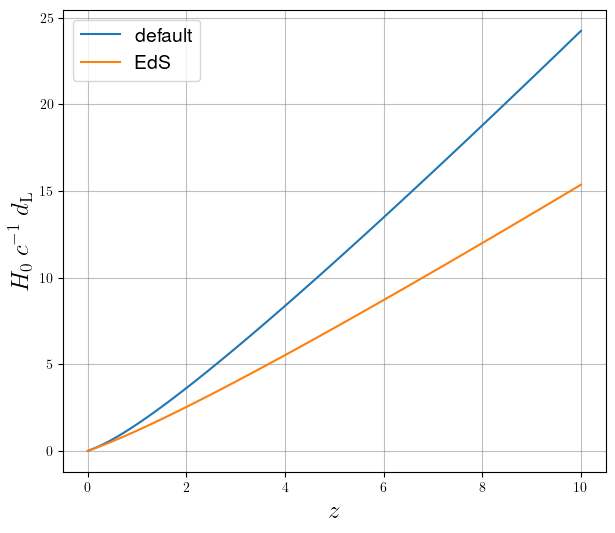

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

ax.plot(z_axis, d_l, label='default')
ax.plot(z_axis, d_l_eds, label='EdS')

ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', alpha=0.5, linestyle='-')
ax.yaxis.grid(color='gray', alpha=0.5, linestyle='-')

ax.set_xlabel('$z$', fontsize=18)
ax.set_ylabel(r'$ H_0\ c^{-1}\ d_\mathrm{L}$', fontsize=18)

ax.legend(fontsize=14)

fig.savefig('/Users/yaronetokayer/Yale Drive/Classes/PHYS 600/phys600 hw/phys600 hw 3/d_l_plot.png',
           dpi=300, bbox_inches='tight')

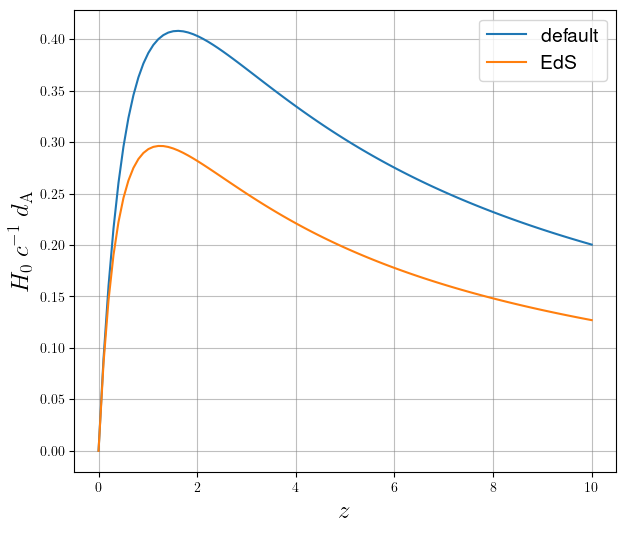

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

ax.plot(z_axis, d_a, label='default')
ax.plot(z_axis, d_a_eds, label='EdS')

ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', alpha=0.5, linestyle='-')
ax.yaxis.grid(color='gray', alpha=0.5, linestyle='-')

ax.set_xlabel('$z$', fontsize=18)
ax.set_ylabel(r'$ H_0\ c^{-1}\ d_\mathrm{A}$', fontsize=18)

ax.legend(fontsize=14)

fig.savefig('/Users/yaronetokayer/Yale Drive/Classes/PHYS 600/phys600 hw/phys600 hw 3/d_a_plot.png',
           dpi=300, bbox_inches='tight')

### Looking Back

In [11]:
def t_l(z, h, Om0, Ode0):
    '''
    Function to compute the lookback time as a function of z

    Inputs:
    z - redshift
    h - H0/(100 km/s/Mpc)
    Om0 - Fractional matter density at z=0
    Ode0 - Fractional dark energy density at z=0

    Returns:
    t_l - lookback time in years
    '''

    H0 = h * 100 * u.km / u.s / u.Mpc

    z_array = np.linspace(0, z, 1000)

    integrand = 1 / H0 / ( 1 + z_array ) / np.sqrt(Om0 * ( 1 + z_array )**3 + Ode0)
    return np.trapz(integrand, x=z_array).to(u.year)

In [12]:
def t_l_to_z(t_l_target, h, Om0, Ode0, tolerance=1e-6):
    '''
    Function to find redshift (z) given the lookback time (t_l) using a bisection method.

    Inputs:
    t_l_target - Lookback time (astropy units expected)
    h - H0/(100 km/s/Mpc)
    Om0 - Fractional matter density at z=0
    Ode0 - Fractional dark energy density at z=0
    tolerance - Tolerance for the bisection method convergence

    Returns:
    z - Redshift corresponding to the given lookback time
    '''

    # Initialize the search interval for z
    z_low, z_high = 0.0, 1e3

    # Perform the bisection search
    while z_high - z_low > tolerance:
        z_mid = (z_low + z_high) / 2
        t_mid = t_l(z_mid, h, Om0, Ode0)
        if t_mid > t_l_target:
            z_high = z_mid
        else:
            z_low = z_mid

    # The bisection method has converged; return the redshift
    return z_mid

In [13]:
# Compute z for t_l = 1e10 years

h = 0.7
Om0 = 0.3
Ode0 = 0.7
t_l_target = 1e10 * u.year

t_l_to_z(t_l_target, h, Om0, Ode0)

1.8555903807282448

Check our work for $t_\mathrm{t}$ using Astropy

In [14]:
z=1.8555903807282448
cosmo.lookback_time(z)

<Quantity 9.99999559 Gyr>

We are correct to 3 significant figures, as required.

## Problem 3

To what redshift is our expansion accurate to 10%?  To answer this, we create two functions: one that computes the exact numerical integral $\chi(z)$, and another that computes the series expansion to third order.  Then we use a bisection method to find the $z$ at which the expansion differs by 10%.

In [15]:
def chi(z, Om0, Ode0):
    '''
    Function to compute the dimensionless comoving distance as a function of z

    Inputs:
    z - redshift
    Om0 - Fractional matter density at z=0
    Ode0 - Fractional dark energy density at z=0

    Returns:
    chi - dimensionless comoving distance (H_0 \chi * c^-1)
    '''

    z_array = np.linspace(0, z, 1000)

    integrand = 1 / np.sqrt( Om0 * ( 1 + z_array )**3 + Ode0 + (1 - Om0 - Ode0) * ( 1 + z_array )**2 )
    return np.trapz(integrand, x=z_array)

In [16]:
def chi_thirdorder(z, Om0, Ode0):
    '''
    Function to compute the approximate dimensionless comoving distance to third order in z 
    as a function of z

    Inputs:
    z - redshift
    Om0 - Fractional matter density at z=0
    Ode0 - Fractional dark energy density at z=0

    Returns:
    chi - dimensionless comoving distance (H_0 \chi * c^-1)
    '''

    z_array = np.linspace(0, z, 1000)

    integrand = (
        1 
        + ( ( -2 + 2*Ode0 - Om0 ) / 2 ) * z_array 
        + ( ( 8 - 20*Ode0 + 12*Ode0**2 + 4*Om0 + 3*Om0**2 - 12*Ode0*Om0 ) / 8 ) * z_array**2 
    )
    
    return np.trapz(integrand, x=z_array)

In [17]:
# Initialize the search interval for z
z_low, z_high = 0.0, 2

tolerance = 1e-6 # Precision of z
target = 0.1 # Looking for delta to be within 10%

# Perform the bisection search
while z_high - z_low > tolerance:
    z_mid = (z_low + z_high) / 2
    delta_mid = np.abs(( chi_thirdorder(z_mid, Om0, Ode0) - chi(z_mid, Om0, Ode0) ) / chi(z_mid, Om0, Ode0)) # % pct error
    if delta_mid > target:
        z_high = z_mid
    else:
        z_low = z_mid

z_mid

1.2042932510375977

We repeat the procedure for a first order expansion to see at what redshift we begin to probe the cosmological density parameters.

In [18]:
# Initialize the search interval for z
z_low, z_high = 0.0, 2

tolerance = 1e-6 # Precision of z
target = 0.1 # Looking for delta to be within 10%

# Perform the bisection search
while z_high - z_low > tolerance:
    z_mid = (z_low + z_high) / 2
    delta_mid = np.abs(( z_mid - chi(z_mid, Om0, Ode0) ) / chi(z_mid, Om0, Ode0)) # % pct error
    if delta_mid > target:
        z_high = z_mid
    else:
        z_low = z_mid

z_mid

0.3857755661010742